# The Qmod Workshop - Part 2: Higher-Level Concepts

This is the second part of the Qmod workshop, covering exercises 6 through 10. Make sure to go through Part 1 before continuing with this notebook.

In [ ]:
!pip install -q Classiq -U

In [ ]:
import classiq
classiq.authenticate()

In [3]:
from classiq import *

### Exercise 6 - Exponentiation and Pauli Operators

The Qmod language supports different classical types: scalars, arrays, and structs. Structs are objects with member variables, or fields.

See also [Classical Types](https://docs.classiq.io/latest/user-guide/platform/qmod/language-reference/classical-types/#structs).

The builtin struct type `PauliTerm` is defined as follows:

In [59]:
@struct
class PauliTerm:
    pauli: CArray[Pauli]
    coefficient: CReal

Note that `Pauli` is an enum for all the Pauli matrices (I, X, Y, Z).

Pauli based hamiltonian can be represented as a list of `PauliTerm`s. A Pauli operator defined this way is the argument to a hamiltonian evolution functions.

In this exercise we will use the Suzuki-Trotter function to find the evolution of `H=0.5XZXX + 0.25YIZI + 0.3 XIZY` (captured as a literal value for the pauli-operator), with the evolution coefficient being 3, the order being 2, and use 4 repetitions.

The declaration of the `suzuki_trotter` function is:

In [60]:
@qfunc(external=True)
def suzuki_trotter(
    pauli_operator: CArray[PauliTerm],
    evolution_coefficient: CReal,
    order: CInt,
    repetitions: CInt,
    qbv: QArray[QBit],
) -> None:
    pass

Fill in the missing parts of the following code in order to complete this exercise:

In [61]:
from classiq import *


@qfunc
def main(q: Output[QArray[QBit]]) -> None:
    allocate(4, q)
    suzuki_trotter(
        [ PauliTerm(pauli=[Pauli.X, Pauli.Z, Pauli.X, Pauli.X], coefficient=0.5),
          PauliTerm(pauli=[Pauli.Y, Pauli.I, Pauli.Z, Pauli.I], coefficient=0.25),
          PauliTerm(pauli=[Pauli.X, Pauli.I, Pauli.Z, Pauli.Y], coefficient=0.3)
         ],
        evolution_coefficient=3,
        repetitions=4,
        order=2,
        qbv=q,
    )


qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/9b2f6f62-9b9a-47d4-9c80-4bb9eea4f36d?version=0.41.2


### Exercise 7 - Basic Arithmetics

#### Exercise 7a
In this exercise we will use quantum numeric variables and calculate expressions over them.

See details on the syntax of numeric types under [Quantum types](https://docs.classiq.io/latest/user-guide/platform/qmod/language-reference/quantum-types/#syntax).
See more on quantum expressions under [Numeric assignment](https://docs.classiq.io/latest/user-guide/platform/qmod/language-reference/statements/numeric-assignment/)

Create the following quantum programs:
1. Initialize variables `x=2`, `y=7` and computes `res = x + y`.
2. Initialize variables `x=2`, `y=7` and computes `res = x * y`.
3. Initialize variables `x=2`, `y=7`, `z=1` and computes `res = x * y - z`.

Guidance:
* Use the operator `|=` to perform out-of-place assignment of arithmetic expression.
* To initialize the variables, use the function `prepare_int`.


In [62]:
from classiq import *

@qfunc
def main(res: Output[QNum]) -> None:
  x = QNum('x')
  prepare_int(2, x)
  y = QNum('y')
  prepare_int(7, y)

  #1. Initialize variables x=2, y=7 and computes res = x + y.
  res |= x+y

  #2. Initialize variables x=2, y=7 and computes res = x * y.
  # res |= x*y

  #3. Initialize variables x=2, y=7, z=1 and computes res = x * y - z
  # res |= x*y-z


qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/99dd77a9-a738-42dc-bf30-556d559377e4?version=0.41.2


#### Exercise 7b
Declare `x` to be a 2-qubit variable and `y` to be 3-qubit variable.

We will perform an addition of two superposition states: `x` is an equal superposition of `0` and `2`, and `y` is an equal superposition of `1`, `2`, `3`, and `6`.

1. Use `prepare_state` to initialize `x` and `y`. Note that `prepare_state` works with probabilities, not amplitudes.
   The declaration of the `prepare_state` function is:
   ```
        @qfunc(external=True)
        def prepare_state(
            probabilities: CArray[CReal],
            bound: CReal,
            out: Output[QArray[QBit]],
        ) -> None:
            pass
   ```
   (Set the bound to 0 in your code)
2. Compute `res = x + y`. Execute the resulting circuit. What did you get?

In [64]:
from classiq import *

@qfunc
def main(res: Output[QNum]) -> None:
  x = QNum('x')
  y = QNum('y')

  prepare_state(probabilities=[0.5,0,0.5,0], bound=0.01, out=x)
  prepare_state(probabilities=[0,1/4,1/4,1/4,0,0,1/4,0], bound=0.01, out=y)

  res |= x+y


qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/6c198e8d-ea40-4032-94e2-69c8449b5e96?version=0.41.2


### Exercise 8 - Within-Apply

The within-apply statement applies the pattern `U_dagger V U` that appears frequently in quantum computing.
It allows you to compute some function `V` within the context of another function `U`, and afterward uncompute `U` in order to release auxiliary qubits storing intermediate results.

See also [Within Apply](https://docs.classiq.io/latest/user-guide/platform/qmod/language-reference/statements/within-apply/).

#### Exercise 8a

In this exercise, we will use within-apply to compute an arithmetic expression in steps.

Use the `within_apply` operation to calculate `res = x + y + z` from a two-variable addition building block with the following steps:
1. Add `x` and `y`
2. Add the result to `z`
3. Uncompute the result of the first operation

For simplicity, initialize the registers to simple integers: `x=3`, `y=5`, `z=2`.

Hints:

* Use a temporary variable.
* Wrap the arithmetic operation in a function.

Execute the circuit and make sure you obtain the expected result.

In [67]:
from classiq import *

@qfunc
def my_add_two(a: QNum, b:QNum, res:Output[QNum]) -> None:
  res |= a+b

@qfunc
def my_adder(a: QNum, b:QNum, c:QNum, res:Output[QNum]):
  tmp = QNum('tmp')
  within_apply(lambda : my_add_two(a,b,tmp), lambda :my_add_two(tmp,c, res))

@qfunc
def main(res: Output[QNum]) -> None:
  x, y, z = QNum('x'), QNum('y'), QNum('z')
  prepare_int(3,x), prepare_int(5,y), prepare_int(2,z)

  my_adder(x,y,z,res)

qmod = create_model(main)
#qprog_with_constraints = set_constraints(qmod, Constraints(optimization_parameter="width"))
qprog = synthesize(qmod)
show(qprog)


# Depth: 65
# Width: 16

Opening: https://platform.classiq.io/circuit/28c69eee-98a2-47e8-ad3d-1470d6246a4d?version=0.41.2


#### Exercise 8b

Why should we use `within-apply` and not just write three concatenated functions?
To understand the motivation, we will create another arithmetic circuit.
This time, however, we will also set Classiq’s synthesis engine to optimize on the circuit’s number of qubits, i.e., its width.

Setting constraints can be done via the `set_constraints` operation - see [here](https://docs.classiq.io/latest/user-guide/platform/synthesis/constraints/).

Perform the operation `res = w + x + y + z`, where w is initialized to 4 and the rest as before:

1. Add `x` and `y` (as part of the `within_apply` operation)
2. Add the result to `z` (as part of the within_apply operation)
3. Uncompute the result of the first operation (as part of the `within_apply` operation)
4. Add the result of the second operation to `w`. There’s no need to perform another uncomputation, as this brings our calculation to an end.

Create the model, optimize on the circuit’s width, and run the circuit. Can you identify where qubits have been released and reused?

In [69]:
from classiq import *


@qfunc
def main(res: Output[QNum]) -> None:
  x, y, z, w = QNum('x'), QNum('y'), QNum('z'), QNum('w')
  prepare_int(3,x) , prepare_int(5,y), prepare_int(2,z), prepare_int(4,w)
  tmp1 = QNum('tmp1')
  my_adder(x,y,z,tmp1)
  my_add_two(tmp1,w,res)


qmod = create_model(main)
qprog_with_constraints = set_constraints(qmod, Constraints(optimization_parameter="width"))
qprog = synthesize(qprog_with_constraints)
show(qprog)

# Depth: 97
# Width: 21

Opening: https://platform.classiq.io/circuit/55299895-1b7a-4dff-b847-a7e594076344?version=0.41.2


#### Bonus: Use a Single Arithmetic Expression

What happens when we don't manually decompose this expression?

Use Classiq’s arithmetic engine to calculate `res |= x + y + z + w` and optimize for width.
Look at the resulting quantum program - can you identify the computation and uncomputation blocks? What else did you notice?

In [70]:
from classiq import *

@qfunc
def main(res: Output[QNum]) -> None:
  x, y, z, w = QNum('x'), QNum('y'), QNum('z'), QNum('w')
  prepare_int(3,x)
  prepare_int(5,y)
  prepare_int(2,z)
  prepare_int(4,w)

  res |= x+y+z+w

qmod = create_model(main)
qprog_with_constraints = set_constraints(qmod, Constraints(optimization_parameter="width"))
qprog = synthesize(qprog_with_constraints)
show(qprog)

# Depth: 67
# Width: 12

Opening: https://platform.classiq.io/circuit/179fdc1e-9ada-4bac-8292-7a246e70f023?version=0.41.2


### Exercise 9 - In-place Arithmetics

For the following exercise we will use numeric quantum variables that represent fixed-point reals.

Arithmetic expressions can be calculated in-place into a target variable, without allocating new qubits to store the result. This is done using the in-place-xor operator.

See also [Numeric assignment](https://docs.classiq.io/latest/user-guide/platform/qmod/language-reference/statements/numeric-assignment/#semantics).

In-place assignment is often used to nest arithmetic expressions under quantum operators. Note that out-of-place assignment requires its left-value variable to be un-initialized, and therefore cannot be used under an operator if the variable is declared outside its scope. Applying operators to arithmetic expressions is required in many algorithms. One example is the piecewise evaluation of mathematical functions - calculating different expressions over `x` depending on the subdomain where `x` falls.

For this exercise, replace the missing parts in the code snippet below to evaluate the result of:

$$
f(x) = \begin{cases}
      2x + 1 & \text{ if } 0 \leq x < 0.5 \\
      x + 0.5 & \text{ if } 0.5 \leq x < 1
   \end{cases}
$$

Notes:
- We cannot use `x` directly as the control variable in a `constrol` operator, because it also occurs in the nested scope. to determine if `x` is in the lower or higher half of the domain we duplicate the most significant bit onto a separate variable called `label`.
- In Python assignment operators cannot be used in lambda expressions, so the computation of the function needs to be factored out to a named Python function (but not necessarily a Qmod function).


In [71]:

from classiq import *


def linear_func(a: float, b: float, x: QNum, res: QNum) -> None:
    res ^= a * x + b


@qfunc
def dup_msb(qba: QArray[QBit], msb: QBit) -> None:
    CX(qba[qba.len - 1], msb)


@qfunc
def main(x: Output[QNum[3, False, 3]], res: Output[QNum[5, False, 3]]) -> None:
    allocate(5, res)
    allocate(3, x)
    hadamard_transform(x)

    label = QBit("label")
    allocate(1, label)

    dup_msb(x, label)
    control(label, lambda: linear_func(1.0, 0.5, x, res))  # 0.5 <= x < 1.0
    X(label)
    control(label, lambda: linear_func(2.0, 1.0, x, res))  # 0.0 <= x < 0.5


qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/26f2d5dc-3152-422b-8ec4-e392feba9a7c?version=0.41.2


### Exercise 10 - State-preparation Algorithm using Quantum-if

#### Binding
The `bind` operation allows to convert smoothly between different quantum types and split or slice bits when necessary. Here’s an example:

In [72]:
from classiq import *



from classiq import *
from math import pi


@qfunc
def main(res: Output[QArray[QBit]]) -> None:
    x: QArray[QBit] = QArray("x")
    allocate(3, x)
    hadamard_transform(x)

    lsb = QBit("lsb")
    msb = QNum("msb", 2, False, 0)
    bind(x, [lsb, msb])

    control(msb == 1, lambda: RY(pi / 3, lsb))   # msb==1 <==> bit1 bit2 == 01 (binary of decimal 1)

    bind([lsb, msb], res)

model = create_model(main)
qprog = synthesize(model)
show(qprog)

Opening: https://platform.classiq.io/circuit/dec84951-50f2-46d1-a9ab-b1456a4f718c?version=0.41.2


The first `bind` operation splits the 3-qubit register `x` into the 2-qubit and single-qubit registers `lsb` and `msb`, respectively.

After the `bind` operation:
1. The registers `lsb` and `msb` can be operated on as separated registers.
2. The register`x` is consumed and can no longer be used.

The second `bind` operation concatenates the registers to the output register `res`.

For this exercise, fill in the missing code parts in the above snippet and use the `control` statement to manually generate the following lovely 3-qubit probability distribution: `[1/8, 1/8, 1/8 -sqrt(3)/16, 1/8 + sqrt(3)/16, 1/8, 1/8, 1/8, 1/8]`.

The following series of gates generate it:

Perform the Hadamard transform on all three qubits.

Apply a rotation on the LSB (least-significant bit) conditioned by the MSB being |0> and the second to last MSB being |1>. How would you write this condition using a QNum?

The following series of gates generate it:
1. Perform the Hadamard transform on all three qubits.
2. Apply a `pi/3` rotation on the LSB (least-significant bit) conditioned by the MSB being |0> and the second to last MSB being |1>. How would you write this condition using a QNum?

If you want to validate your results without looking at the full solution, compare them to running using Classiq’s built-in `prepare_state` function.


In [73]:
from classiq import *
from classiq.qmod.symbolic import sqrt
from math import pi
prob_list= [
            1 / 8,
            1 / 8,
            1 / 8-sqrt(3) / 16,
            1 / 8 + sqrt(3) / 16,
            1 / 8,
            1 / 8,
            1 / 8,
            1 / 8
        ]
@qfunc
def pre_prepared_state(q: QArray[QBit]) -> None:
    prepare_state(
        [
            1 / 8,
            1 / 8,
            1 / 8,
            1 / 8-sqrt(3) / 16,
            1 / 8 + sqrt(3) / 16,
            1 / 8,
            1 / 8,
            1 / 8,
        ],
        0.0,
        q,
    )


@qfunc
def main(res: Output[QArray[QBit]]) -> None:

  x: QArray[QBit] = QArray("x")
  allocate(3, x)
  hadamard_transform(x)

  lsb = QBit("lsb")
  msb = QNum("msb", 2, False, 0)
  bind(x, [lsb, msb])
  control(msb == 1, lambda: RY(pi / 3, lsb))

  bind([lsb, msb], res)



model = create_model(main)
qprog = synthesize(model)
show(qprog)
job = execute(qprog)


Opening: https://platform.classiq.io/circuit/b523045c-7081-4d6a-b6cd-592f6702394b?version=0.41.2


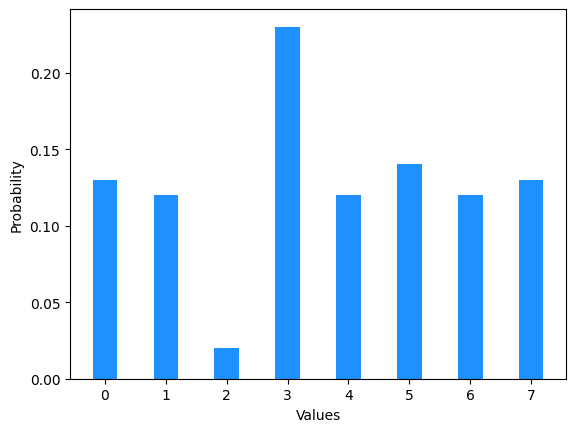

In [74]:
import matplotlib.pyplot as plt

job = execute(qprog)
results = job.result()
parsed_counts = results[0].value.parsed_counts
# Ploting a bar chart to see
# total shots uesed
shots = sum([sampled_state.shots for sampled_state in parsed_counts])
histo =dict([(sampled_state.state['res'], round(sampled_state.shots/shots,2)) for sampled_state in parsed_counts])

values = list(histo.keys())
prob = list(histo.values())
plt.bar(values, prob, color ='dodgerblue',
        width = 0.4)

plt.xlabel("Values")
plt.ylabel("Probability")

plt.show()

# We notice clearly that both 2(010) & 3(011) have diffrent probabilities, as these the only cases where MSB = 1(01)

In [75]:
# verifying the results
@qfunc
def main(y: Output[QNum]) -> None:
  prepare_state(prob_list,0.0,y)

model2 = create_model(main)
qprog2 = synthesize(model2)
show(qprog2)



Opening: https://platform.classiq.io/circuit/fddc8354-cc2c-4afc-badf-126cd268f47c?version=0.41.2


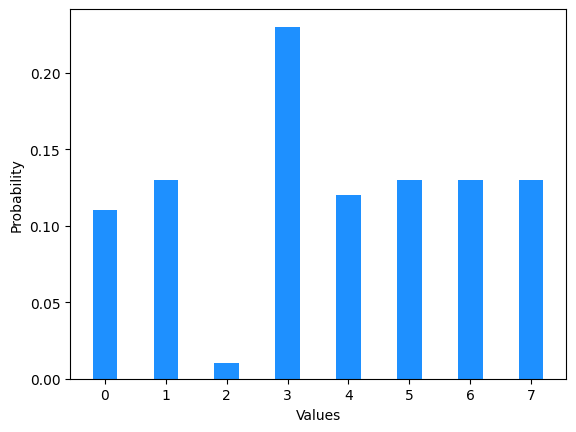

In [76]:
job = execute(qprog2)
results = job.result()
parsed_counts = results[0].value.parsed_counts
# Ploting a bar chart to see
# total shots uesed
shots = sum([sampled_state.shots for sampled_state in parsed_counts])
histo =dict([(sampled_state.state['y'], round(sampled_state.shots/shots,2)) for sampled_state in parsed_counts])

values = list(histo.keys())
prob = list(histo.values())
plt.bar(values, prob, color ='dodgerblue',
        width = 0.4)

plt.xlabel("Values")
plt.ylabel("Probability")

plt.show()

# We notice clearly that both 2(010) & 3(011) have diffrent probabilties, as these the only cases where MSB = 1(01)